In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import os
import numpy as np
import cv2
import sys
import re
import random
from time import time
from PIL import Image
from copy import deepcopy
from collections import defaultdict
from itertools import islice
from tqdm import tqdm_notebook
from time import time
from easydict import EasyDict
from IPython.core.debugger import set_trace
from matplotlib import pyplot as plt
from warnings import filterwarnings

import torch
from torch import nn
import torch.nn.functional as F
from torch import autograd
from torch.utils.data import DataLoader
from torchvision.transforms import Resize, ToTensor, Compose, Grayscale

from mvn.utils.multiview import update_camera
from mvn.utils.misc import get_capacity, description
from mvn.utils import volumetric
from mvn.models.v2v_models import V2VModel_v1
from mvn.models.temporal import Seq2VecRNN,\
                                Seq2VecCNN, \
                                Seq2VecRNN2D, \
                                Seq2VecCNN2D, \
                                get_encoder, \
                                FeatureDecoderLSTM, \
                                StylePosesLSTM

from IPython.core.debugger import set_trace


from mvn.utils.img import image_batch_to_numpy, denormalize_image,to_numpy
from mvn.models.pose_hrnet import get_pose_net as get_pose_hrnet
from mvn.models.pose_resnet import get_pose_net as get_pose_resnet
from mvn.models import pose_resnet, pose_hrnet

from mvn.utils.multiview import project_3d_points_to_image_plane_without_distortion
from mvn.utils.vis import draw_2d_pose
from mvn.utils import img
from mvn.utils import multiview
from mvn.utils import volumetric
from mvn.utils.op import get_coord_volumes, unproject_heatmaps, integrate_tensor_3d_with_coordinates
from mvn.utils import vis
from mvn.utils import misc
from mvn.utils import cfg
from mvn.datasets import utils as dataset_utils
from mvn.datasets.human36m import Human36MMultiViewDataset, Human36MTemporalDataset
from mvn.utils.misc import get_start_stop_frame_indxs, index_to_name, get_error_diffs, normalize_temporal_images_batch, retval, get_capacity

from train import setup_human36m_dataloaders

from mvn.models.triangulation import VolumetricTriangulationNet
from mvn.models.volumetric_adain import VolumetricTemporalAdaINNet
from mvn.models.volumetric_grid import VolumetricTemporalGridDeformation

from mvn.models.v2v import V2VModel, SPADE, V2VModel, R2D, SqueezeLayer

from IPython.core.debugger import set_trace

%matplotlib inline

retval = {
    'subject_names': ['S1', 'S5', 'S6', 'S7', 'S8', 'S9', 'S11'],
    'camera_names': ['54138969', '55011271', '58860488', '60457274'],
    'action_names': [
        'Directions-1', 'Directions-2',
        'Discussion-1', 'Discussion-2',
        'Eating-1', 'Eating-2',
        'Greeting-1', 'Greeting-2',
        'Phoning-1', 'Phoning-2',
        'Posing-1', 'Posing-2',
        'Purchases-1', 'Purchases-2',
        'Sitting-1', 'Sitting-2',
        'SittingDown-1', 'SittingDown-2',
        'Smoking-1', 'Smoking-2',
        'TakingPhoto-1', 'TakingPhoto-2',
        'Waiting-1', 'Waiting-2',
        'Walking-1', 'Walking-2',
        'WalkingDog-1', 'WalkingDog-2',
        'WalkingTogether-1', 'WalkingTogether-2']
}

JOINT_H36_DICT = {0:'RFoot',
                 1:'RKnee',
                 2:'RHip',
                 3:'LHip',
                 4:'LKnee',
                 5:'LFoot',
                 6:'Hip',
                 7:'Spine',
                 8:'Thorax',
                 9:'Head',
                 10:'RWrist',
                 11:'RElbow',
                 12:'RShoulder',
                 13:'LShoulder',
                 14:'LElbow',
                 15:'LWrist',
                 16:'Neck/Nose'}

JOINT_NAMES_DICT = {
                    0: "nose",
                    1: "left_eye",
                    2: "right_eye",
                    3: "left_ear",
                    4: "right_ear",
                    5: "left_shoulder",
                    6: "right_shoulder",
                    7: "left_elbow",
                    8: "right_elbow",
                    9: "left_wrist",
                    10: "right_wrist",
                    11: "left_hip",
                    12: "right_hip",
                    13: "left_knee",
                    14: "right_knee",
                    15: "left_ankle",
                    16: "right_ankle"
                }

CONNECTIVITY_DICT = {
    'cmu': [(0, 2), (0, 9), (1, 0), (1, 17), (2, 12), (3, 0), (4, 3), (5, 4), (6, 2), (7, 6), (8, 7), (9, 10), (10, 11), (12, 13), (13, 14), (15, 1), (16, 15), (17, 18)],
    'coco': [(0, 1), (0, 2), (1, 3), (2, 4), (5, 7), (7, 9), (6, 8), (8, 10), (11, 13), (13, 15), (12, 14), (14, 16), (5, 6), (5, 11), (6, 12), (11, 12)],
    "mpii": [(0, 1), (1, 2), (2, 6), (5, 4), (4, 3), (3, 6), (6, 7), (7, 8), (8, 9), (8, 12), (8, 13), (10, 11), (11, 12), (13, 14), (14, 15)],
    "human36m": [(0, 1), (1, 2), (2, 6), (5, 4), (4, 3), (3, 6), (6, 7), (7, 8), (8, 16), (9, 16), (8, 12), (11, 12), (10, 11), (8, 13), (13, 14), (14, 15)],
    "kth": [(0, 1), (1, 2), (5, 4), (4, 3), (6, 7), (7, 8), (11, 10), (10, 9), (2, 3), (3, 9), (2, 8), (9, 12), (8, 12), (12, 13)],
}

collate_fn = dataset_utils.make_collate_fn(randomize_n_views=False,
                                           min_n_views=None,
                                           max_n_views=None)

def tensor2np(tensor):
    return tensor.clone().detach().cpu().numpy()

def visualize_torch_feature_maps(features_maps, max_channels=8):
    features_maps_np = tensor2np(features_maps)
    C_features_maps = features_maps_np.shape[-3]
    n_channels_style_vis = min(int(np.sqrt(C_features_maps)), max_channels)
    fig,axes = plt.subplots(ncols=n_channels_style_vis, 
                            nrows=n_channels_style_vis, 
                            figsize=(n_channels_style_vis*2,n_channels_style_vis*2))
    for i in range(n_channels_style_vis):
        for j in range(n_channels_style_vis):
            channel_number = i*n_channels_style_vis + j
            axes[i,j].imshow(features_maps_np[channel_number])

device = 'cuda:0' #torch.cuda.current_device()
print ('Done')
# torch.backends.cudnn.benchmark = True
# torch.backends.cudnn.enabled = True 

Done


In [2]:

# experiment_type='resnet_50_3d'
# experiment_name='h36_sv32_dist_spade3d-h128-interpolate-gn-bn-conf-leakyrelu_s2v-R2D-2l-RGB-64-1e-4_vf64_resnet50-gn_dt-6_dil-3-1-1_lr-1e-4_norot_gradclip-1e-2@10.04.2020-17:06:07'

experiment_type='resnet_50_3d' 
# experiment_name='h36_sv32_dist_spade3d-h128-unproject-gn-bn-conf-leakyrelu_s2v-R2D-upscale-1l-avg-RGB-112-64-1e-5_vf64_resnet50-gn_pf-1e-3_dt-10_dil-1_bs1-1_lr-1e-4_norot_gradclip-1e-2@07.05.2020-01:37:15'
# experiment_name='h36_sv32_dist_spade3d-h128-unproject-gn-bn-conf-leakyrelu_s2v-R2D-time-avg-1l-RGB-112-64-1e-5-norelu_vf64_resnet50-gn_pf-1e-3_dt-10_dil-1_bs1-1_lr-1e-4_norot_gradclip-1e-2_C-01:37:15@10.05.2020-17:53:15'   
experiment_name='h36_sv32_dist_spade3d-inverse-h128-unproject-gn-bn-conf-leakyrelu_s2v-v2v-64-norelu-lr1e-3_vf64_resnet50-stylegrad-gn_pf-1e-3_dt-9_dil-1_bs10-1_lr-1e-4_norot_gradclip-1e-2_C-17:53:15@12.05.2020-16:04:54'

# experiment_type='resnet_50_3d'
# experiment_name='h36_sv32_dist_stack3d-interpolate-gn_s2v-v2v-256-128-64-32-gn-decoder-1e-4_vf32_f2v-features-noupscale-C0-256-group_resnet50-gn-nostylegrad_dt-11-intermediate_dil-3-1-1_lr-1e-4_norot@03.04.2020-10:37:42'

experiment_root = os.path.join('../logs/', experiment_type, experiment_name)
config_path = experiment_root + '/config.yaml'

config = cfg.load_config(config_path)
config.dataset.dilation = 5
config.dataset.val.retain_every_n_frames_in_test = 1

train_loader, val_loader, _ = setup_human36m_dataloaders(config,
                                             is_train=True,
                                             distributed_train=False)

batch_size, dt, dilation = val_loader.batch_size, val_loader.dataset.dt, val_loader.dataset.dilation

pivot_type = config.dataset.pivot_type 
keypoints_per_frame = config.dataset.keypoints_per_frame if hasattr(config.dataset, 'keypoints_per_frame') else False
pivot_position = {'first':-1, 'intermediate':dt//2}[pivot_type]

if not hasattr(config.model.backbone, 'group_norm'):
    config.model.backbone.group_norm = False

print('Batch size:', batch_size, '\n',\
      'dt:', dt, '\n',\
      'dilation:', dilation, '\n',\
      'pivot_type:', pivot_type, '\n',\
      'pivot_position:', pivot_position,'\n',\
      'keypoints_per_frame', keypoints_per_frame)


Batch size: 1 
 dt: 9 
 dilation: 5 
 pivot_type: first 
 pivot_position: -1 
 keypoints_per_frame False


# Check dataset output

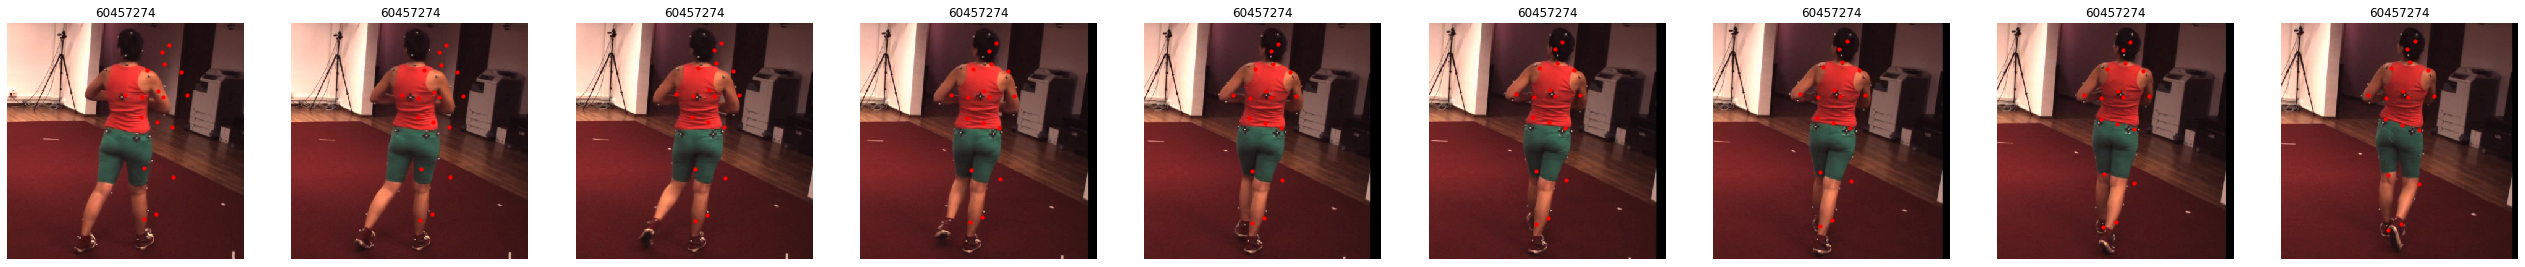

In [3]:
start=1
step = 5
n_sequences_vis = 1
for batch in islice(train_loader,start, start+n_sequences_vis*step, step):
# for batch in train_loader:

    n_views = batch['images'].shape[1]
    batch_size = batch['images'].shape[0]
    
    fig, axes = plt.subplots(ncols=n_views, nrows=1, figsize=(5 * n_views, 5))
    for i in range(n_views):
        # first row
        detection = batch['detections'][0][i]
        *bbox, c = detection
        
        image = batch['images'][0][i]
        image = denormalize_image(image).astype(np.uint8)
        image = image[..., ::-1]  # bgr -> rgb
        camera_name = batch['cameras'][i][0].name
        title = "{}, detection conf: {:.3}".format(camera_name, c)
        
        # second row
        keypoints_3d = batch['keypoints_3d'][0][:, :3]
        proj_matrix = batch['cameras'][i][0].projection
#         image_shape_before_resize = batch['image_shapes_before_resize'][0][i]
        image_shape = image.shape[:2]

        keypoints_2d_wrt_new = multiview.project_3d_points_to_image_plane_without_distortion(proj_matrix, keypoints_3d)
#         keypoints_2d_wrt_orig = transform_points_after_crop_and_resize(keypoints_2d_wrt_new, (bbox[0], bbox[1]), image_shape_before_resize, image_shape, forward=True)
        
        axes[i].set_xlim(0, image.shape[1])
        axes[i].set_ylim(0, image.shape[0])
        axes[i].invert_yaxis()
        axes[i].imshow(image)
        axes[i].scatter(keypoints_2d_wrt_new[:, 0], keypoints_2d_wrt_new[:, 1], s=10, c='red')
        axes[i].set_title(camera_name)
        axes[i].axis('off')
    plt.show()
    break

# Model

In [4]:
# config.model.cuboid_multiplier = 1.0
# config.model.rotation = False
# config.model.transfer_cmu_to_human36m = False
# config.model.encoder_normalization_type = 'group_norm'
# config.model.upscale_bottleneck = False
# config.model.f2v_intermediate_channels = config.model.intermediate_channels    
# config.model.f2v_normalization_type = 'group_norm'   
# config.model.v2v_type = 'v1'
# config.model.spade_broadcasting_type = 'unprojecting'

model = {
    "vol": VolumetricTriangulationNet,
    "vol_temporal_adain":VolumetricTemporalAdaINNet
}[config.model.name](config, device=device).to(device)

print ('Loaded {} model'.format(config.model.name))

Loading pretrained weights from: ./data/pose_resnet_4.5_pixels_human36m.pth
Successfully loaded pretrained weights for backbone
Only resnet50 backbone is used...
backbone:  34.0M
features_sequence_to_vector:  4.77M
encoder:  0.0M
volume_net:  57.39M
process_features:  0.02M
Loaded vol_temporal_adain model


# Check distr

In [5]:
# me = model.motion_extractor.motion_extractor
# ups =  model.motion_extractor.final_layer
# me_p = []
# for p in me.parameters():
#     me_p.append(p.flatten())
# me_p = torch.cat(me_p).detach().cpu().numpy()
# plt.figure(figsize=(10,10))
# plt.hist(me_p, bins=1000)
# plt.yscale('log', nonposy='clip')
# plt.show()

# ups_p = []
# for p in ups.parameters():
#     ups_p.append(p.flatten())
# ups_p = torch.cat(ups_p).detach().cpu().numpy()
# plt.figure(figsize=(10,10))
# plt.hist(ups_p, bins=1000)
# plt.yscale('log', nonposy='clip')
# plt.show()

# Load weights

In [6]:
checkpoints_path = experiment_root + '/checkpoints/'
weights_path = checkpoints_path + 'weights.pth'
weights_dict = torch.load(weights_path)['model_state'] # , map_location=device
REBUILD_STATE_DICT = False

if REBUILD_STATE_DICT:
    model_dict = model.state_dict()
    new_pretrained_state_dict = {}

    for k, v in weights_dict.items():
        if k in model_dict:
            new_pretrained_state_dict[k] = weights_dict[k]
        
    model.load_state_dict(new_pretrained_state_dict, strict=True)
else:
    model.load_state_dict(weights_dict, strict=True)
    
print ('Done')

Done


In [7]:
batch=np.load('batch_sample.npy', allow_pickle=True).item()

### Problems:

 - `proj_matricies_batch` aren't equal along the seq
 - Don't use ReLU after AdaptiveAvgPool3d in R2D, since there is a `process_features` layer for `pivot_features`
 - Camera `t` multiply by -1 -  i don't get it (
 - Rotation (check arrow) to $-\frac{\pi}{2}$ of unprojected image in volumetric represenatation

# Debug before-v2v

In [8]:
self = model

(images_batch, 
keypoints_3d_gt, 
keypoints_3d_validity_gt, 
proj_matricies_batch) = dataset_utils.prepare_batch(batch, device)
print ('Done')

Done


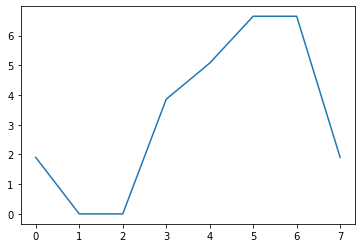

In [9]:
batch_proj_m_diffs = []
for i in range(dt-1):
    batch_proj_m_diffs.append(np.linalg.norm(batch['cameras'][i][0].K - batch['cameras'][i+1][0].K))
plt.plot(batch_proj_m_diffs)    

In [10]:
device = images_batch.device
batch_size, dt = images_batch.shape[:2]
image_shape = images_batch.shape[-2:]
# assert self.dt == dt

return_me_vector = self.use_style_me_for_SPL if hasattr(self, 'use_style_me_for_SPL') else False
decode_second_part = self.use_style_decoder and (self.style_decoder_part == 'after_pivot')
decode_first_part = self.use_style_decoder and (self.style_decoder_part == 'before_pivot')

# FIX
process_only_pivot_image = self.use_motion_extractor and self.motion_extractor_from == 'rgb'
process_first_half_of_images = self.use_style_pose_lstm_loss and (not decode_second_part)

if process_only_pivot_image:
    images_batch_for_features = images_batch[:,self.pivot_index]
elif process_first_half_of_images:
    images_batch_for_features = images_batch[:,:self.pivot_index+1].contiguous()
else:
    images_batch_for_features = images_batch 
print ('Done')    

Done


In [11]:
######################
# FEATURE ECTRACTION #   
######################
if self.use_auxilary_backbone:
    raise NotImplementedError()
else:    
    # forward backbone
    heatmaps, features, _, vol_confidences, bottleneck = self.backbone(images_batch_for_features.view(-1, 3, *image_shape))

    # extract aux_features
    features_shape = features.shape[-2:]
    features_channels = features.shape[1]

    if process_only_pivot_image:
        pivot_features = features
        original_pivot_features = pivot_features.clone().detach()
        pivot_features = self.process_features(pivot_features).unsqueeze(1)
    else:    
        features = features.view(batch_size, -1, features_channels, *features_shape)
        aux_indexes_in_output = np.arange(self.pivot_index) if process_first_half_of_images else self.aux_indexes

        pivot_features = features[:,self.pivot_index,...]
        original_pivot_features = pivot_features.clone().detach()
        pivot_features = self.process_features(pivot_features).unsqueeze(1)
        aux_features = features if self.include_pivot else features[:,aux_indexes_in_output,...].contiguous()

        if decode_second_part:
            # before pivot
            aux_features = aux_features[:,:dt//2,...].contiguous()
            # after pivot
            features_for_loss = features[:,(dt//2)+1:,...].clone().detach()

        if decode_first_part:
            features_for_loss = aux_features.clone().detach()

        # features for style_vector reasoning    
        aux_features = aux_features.view(-1, *aux_features.shape[-3:])

        # extract aux_bottleneck
        if bottleneck is not None:
            bottleneck_shape = bottleneck.shape[-2:]
            bottleneck_channels = bottleneck.shape[1]
            bottleneck = bottleneck.view(batch_size, -1, bottleneck_channels, *bottleneck_shape)
            aux_bottleneck = bottleneck if self.include_pivot else bottleneck[:,aux_indexes_in_output,...].contiguous()
            aux_bottleneck = aux_bottleneck.view(-1, bottleneck_channels, *bottleneck_shape)   

proj_matricies_batch = update_camera(batch, batch_size, image_shape, features_shape, dt, device)
proj_matricies_batch = proj_matricies_batch[:,self.pivot_index,...].unsqueeze(1) # pivot camera 
print ('Done')    

Done


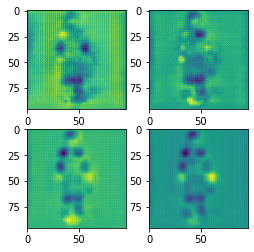

In [12]:
fictive_view=0
batch_index = 0
visualize_torch_feature_maps(pivot_features[batch_index,fictive_view],2)

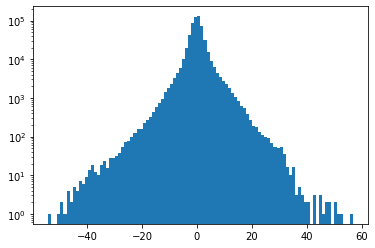

In [13]:
batch_index = 0
pivot_features_np = tensor2np(pivot_features)
plt.hist(pivot_features_np[batch_index].flatten(), bins=100)
plt.yscale('log', nonposy='clip')
plt.show()

In [14]:
###############################
# TEMPORAL FEATURE ECTRACTION #   
###############################
return_me_vector=True
if self.use_motion_extractor:
    if self.motion_extractor_from == 'rgb':
        aux_images = images_batch[:,:self.pivot_index].contiguous()
        if self.resize_images_for_me:
            aux_images = F.interpolate(aux_images.view(-1, 3, *image_shape),size=self.images_me_target_size,  mode='bilinear')
            aux_images = aux_images.view(batch_size, -1, 3, *self.images_me_target_size)
            assert aux_images.dim() > 4 # assert time dim
            assert aux_images.shape[1] > 1 # assert time dim
        if return_me_vector:    
            style_vector, style_vector_me = self.motion_extractor(aux_images.transpose(1,2), return_me_vector=True)
        else:
            style_vector  = self.motion_extractor(aux_images.transpose(1,2), return_me_vector=False)
    elif self.motion_extractor_from == 'features':
        style_vector = self.motion_extractor(aux_features.view(batch_size,
                                                                -1, # time
                                                                features_channels,
                                                                *features_shape).transpose(1,2))
    elif self.motion_extractor_from == 'bottleneck':
        style_vector = self.motion_extractor(aux_bottleneck.view(batch_size,
                                                                 -1, # time 
                                                                 bottleneck_channels, 
                                                                 *bottleneck_shape).transpose(1,2))    
    else:
        raise RuntimeError('Wrong `motion_extractor_from`')    
else:    
    if self.encoder_type == 'backbone':
        aux_bottleneck = aux_bottleneck if self.style_grad_for_backbone else aux_bottleneck.clone().detach()
        encoded_features = self.encoder(aux_bottleneck)
    elif self.encoder_type == 'features': 
        aux_features = aux_features if self.style_grad_for_backbone else aux_features.clone().detach()
        encoded_features = self.encoder(aux_features)
    else:
        raise RuntimeError('Unknown encoder')    

    encoded_features = encoded_features.view(batch_size, -1, *encoded_features.shape[1:]) # [batch_size, dt-1, encoded_fetures_dim]
    if self.f2v_type == 'v2v':
        # encoded_features = torch.transpose(encoded_features.unsqueeze(-1), 1,5).squeeze(1) # make time-dimension new z-coordinate
        encoded_features = torch.transpose(encoded_features, 1,2) # [batch_size, encoded_fetures_dim[0], dt-1, encoded_fetures_dim[1:]]
    style_vector = self.features_sequence_to_vector(encoded_features) # [batch_size, style_vector_dim]
print ('Done')        

Done


In [15]:
self.encoder_type

'features'

In [16]:
style_vector.shape

torch.Size([1, 64, 96, 96])

In [17]:
# self.f2v_backbone = [m for m in self.features_sequence_to_vector.children()][0]
# f2v_backbone_features = self.f2v_backbone(encoded_features)
# n_features_vis=10
# n_times_vis = 8
# fig, axes = plt.subplots(ncols=n_times_vis, nrows=n_features_vis, figsize=(n_features_vis,n_times_vis))
# for n in range(n_features_vis):
#     for i in range(n_times_vis):
#         axes[n,i].imshow(tensor2np(f2v_backbone_features[batch_index,n,i]))

In [18]:
# time_slice = 2
# feature_slice=7
# n_times_vis = 5
# fig, axes = plt.subplots(ncols=n_times_vis, nrows=1)
# for i,ax in enumerate(axes):
#     ax.imshow(tensor2np(style_vector_me[batch_index,feature_slice,i]))

In [19]:
# visualize_torch_feature_maps(style_vector_me[batch_index,:,time_slice])

In [20]:
# style_vector_me_conv = self.motion_extractor.final_layer[0](style_vector_me)
# visualize_torch_feature_maps(style_vector_me_conv[batch_index,:,0])

In [21]:
# style_vector_me_conv_avg = self.motion_extractor.final_layer[1](style_vector_me_conv)
# visualize_torch_feature_maps(style_vector_me_conv[batch_index,:,0])

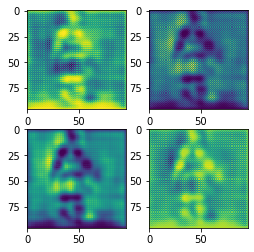

In [22]:
batch_index = 0
visualize_torch_feature_maps(style_vector[batch_index, [7,8,12,14]])

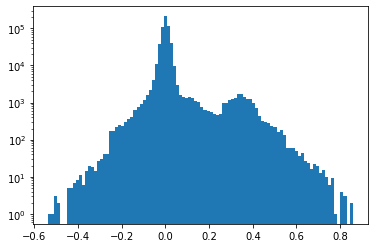

In [23]:
style_vector_np = tensor2np(style_vector)
plt.hist(style_vector_np[batch_index].flatten(), bins=100)
plt.yscale('log', nonposy='clip')
plt.show()

In [24]:
#########
# DEBUG #   
#########
randomize_style=True
if randomize_style:
    idx = torch.randperm(style_vector.nelement())
    style_vector_rand = style_vector.view(-1)[idx].view(style_vector.size())        

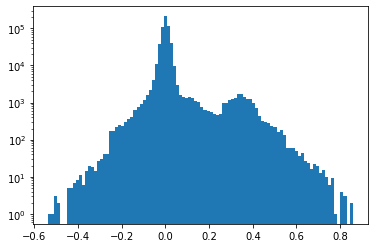

In [25]:
style_vector_rand_np = tensor2np(style_vector_rand)
plt.hist(style_vector_rand_np[batch_index].flatten(), bins=100)
plt.yscale('log', nonposy='clip')
plt.show()

In [26]:
##########
# PELVIS #   
##########            
if self.pelvis_type =='gt':
    tri_keypoints_3d = torch.from_numpy(np.array(batch['keypoints_3d'])[...,:3]).type(torch.float).to(device)
else:
    raise RuntimeError('In absence of precalculated pelvis or gt pelvis, self.use_volumetric_pelvis should be True') 
print ('Done')        

Done


In [27]:
#####################
# VOLUMES CREATING  #   
#####################
coord_volumes, _, base_points = get_coord_volumes(self.kind, 
                                                    self.training, 
                                                    self.rotation,
                                                    self.cuboid_side,
                                                    self.volume_size, 
                                                    device,
                                                    keypoints=tri_keypoints_3d
                                                    )

if self.use_style_pose_lstm_loss:
    lstm_coord_volumes = coord_volumes[:,self.pivot_index+1:,...].contiguous()
if self.keypoints_per_frame:    
    coord_volumes = coord_volumes[:,self.pivot_index,...]
    base_points = base_points[:,self.pivot_index,...]
print ('Done')        

Done


In [28]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
import plotly.graph_objs as go
import colorlover as cl

R = batch['cameras'][self.pivot_index][0].R
t = batch['cameras'][self.pivot_index][0].t

camera_point = np.linalg.inv(R)@t
coords = coord_volumes[0, ::6, ::6, ::6,...].contiguous().view(-1, 3).detach().cpu().numpy()
keypoints = keypoints_3d_gt.view(-1, 3).detach().cpu().numpy()

init_notebook_mode(connected=False) 

color_point = cl.scales['10']['div']['RdYlBu'][1]
color_grid = cl.scales['10']['div']['RdYlBu'][0]
color_kp = cl.scales['10']['div']['RdYlBu'][-1]
plotly_data = []

grid = dict(x = coords[:,0],
            y = coords[:,1],
            z = coords[:,2],
            type = "scatter3d",    
            mode = 'markers',
            marker = dict(size=5,
                          color=color_grid,
                          line=dict(width=0)))

camera_point_data = dict(x = -camera_point[0],
            y = -camera_point[1],
            z = -camera_point[2],
            type = "scatter3d",    
            mode = 'markers',
            marker = dict(size=5,
                          color=color_point,
                          line=dict(width=0)))
plotly_data.append(grid)
plotly_data.append(camera_point_data)


# connections
connectivity = CONNECTIVITY_DICT['human36m']
for (index_from, index_to) in connectivity:
    xs, ys, zs = [np.array([keypoints[index_from, j], keypoints[index_to, j]]) for j in range(3)]

    plotly_data.append(go.Scatter3d(x=xs, y=ys, z=zs,
                         marker=dict(size=4,color='green'),
                         line=dict(color='green',width=2)))

fig = go.Figure(data=plotly_data)

fig.update_xaxes(
    showgrid=True,
    ticks="",
)

iplot(fig, show_link = False)

In [29]:
##########################
# CREATE FEATURE VOLUMES #   
##########################
unproj_features = unproject_heatmaps(pivot_features,  
                                    proj_matricies_batch, 
                                    coord_volumes, 
                                    volume_aggregation_method=self.volume_aggregation_method,
                                    vol_confidences=vol_confidences
                                    )
print ('Done')    

Done


In [30]:
# # create fictive features
# transforms = Compose([Resize((96,96)), Grayscale(), ToTensor()])
# pil_image = Image.open('./arrow.png')
# img_tensor = transforms(pil_image)

# # binarize 
# img_tensor[img_tensor > 0] = 1
# img_tensor[img_tensor < 1.] = 0

# plt.figure()
# plt.imshow(tensor2np(img_tensor)[0])
# plt.figure()
# plt.hist(tensor2np(img_tensor).flatten())
# plt.show()

# unproj_image_tensor = unproject_heatmaps(img_tensor.unsqueeze(0).unsqueeze(0).cuda(), # unsqueeze batch and view  
#                                     proj_matricies_batch, 
#                                     coord_volumes, 
#                                     volume_aggregation_method=self.volume_aggregation_method,
#                                     vol_confidences=vol_confidences
#                                     )

# visualize_torch_feature_maps(unproj_image_tensor[0, 0])

# unproj_feature_indx = 0

# coords_ones = coord_volumes[unproj_image_tensor[:,unproj_feature_indx] == 1.]
# coords_zeros = coord_volumes[unproj_image_tensor[:,unproj_feature_indx] == 0.]


In [31]:
# init_notebook_mode(connected=False) 

# R = batch['cameras'][self.pivot_index][0].R
# t = batch['cameras'][self.pivot_index][0].t
# camera_point = np.linalg.inv(R)@t

# coords_ones_grid = coords_ones.detach().cpu().numpy()
# coords_zeros_grid = coords_zeros.detach().cpu().numpy()
# coord_origin_point = coord_volumes[0][0,0,0].unsqueeze(-1).cpu().numpy()

# color_point = 'rgb(0,0,215)'
# color_grid_ones = cl.scales['10']['div']['RdYlBu'][0]
# color_grid_zeros = 'rgba(253,174,97, 0.1)'
# coord_origin_point_color = 'rgb(0,215,0)'
# grid_zeros_step = 2
# # color_grid_zeros = cl.scales['10']['div']['RdYlBu'][3]
# color_kp = cl.scales['10']['div']['RdYlBu'][-1]
# plotly_data = []

# grid_ones = dict(x = coords_ones_grid[:,0],
#             y = coords_ones_grid[:,1],
#             z = coords_ones_grid[:,2],
#             type = "scatter3d",    
#             mode = 'markers',
#             marker = dict(size=5,
#                           color=color_grid_ones,
#                           line=dict(width=0)))

# grid_zeros = dict(x = coords_zeros_grid[::grid_zeros_step,0],
#             y = coords_zeros_grid[::grid_zeros_step,1],
#             z = coords_zeros_grid[::grid_zeros_step,2],
#             type = "scatter3d",    
#             mode = 'markers',
#             marker = dict(size=5,
#                           color=color_grid_zeros,
#                           line=dict(width=0)))

# coord_origin_point_data = dict(x = coord_origin_point[0],
#             y = coord_origin_point[1],
#             z = coord_origin_point[2],
#             type = "scatter3d",    
#             mode = 'markers',
#             marker = dict(size=5,
#                           color=coord_origin_point_color,
#                           line=dict(width=0)))

# camera_point_data = dict(x = -camera_point[0],
#             y = -camera_point[1],
#             z = -camera_point[2],
#             type = "scatter3d",    
#             mode = 'markers',
#             marker = dict(size=5,
#                           color=color_point,
#                           line=dict(width=0)))

# plotly_data.append(grid_ones)
# plotly_data.append(grid_zeros)
# plotly_data.append(coord_origin_point_data)
# plotly_data.append(camera_point_data)

# fig = go.Figure(data=plotly_data)
# iplot(fig, show_link = False)

In [32]:
######################## 
# CREATE STYLE VOLUMES #   
######################## 
if not self.temporal_condition_type == 'adain':
    if self.spade_broadcasting_type == 'unprojecting':
            style_shape = style_vector.shape[-2:]
            if style_shape != features_shape:
                proj_matricies_style = update_camera(batch, batch_size, image_shape, style_shape, dt, device)
                proj_matricies_style = proj_matricies_style[:,self.pivot_index,...].unsqueeze(1) # pivot camera
            else:
                proj_matricies_style = proj_matricies_batch     
            style_vector_volumes = unproject_heatmaps(style_vector.unsqueeze(1),  
                                                     proj_matricies_style, 
                                                     coord_volumes, 
                                                     volume_aggregation_method=self.volume_aggregation_method,
                                                     vol_confidences=vol_confidences
                                                     )
    elif self.spade_broadcasting_type == 'interpolate':
        style_vector_volumes = F.interpolate(style_vector,
                                             size=(self.volume_size,self.volume_size,self.volume_size), 
                                             mode='trilinear')
    else:
        raise KeyError('Unknown spade_broadcasting_type')
print ('Done')            

Done


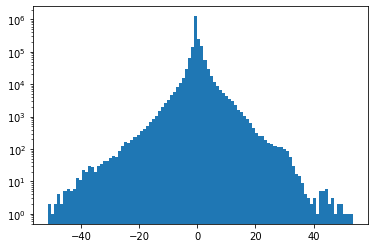

In [33]:
plt.hist(tensor2np(unproj_features[batch_index]).flatten(), bins = 100)
plt.yscale('log', nonposy='clip')
plt.show()

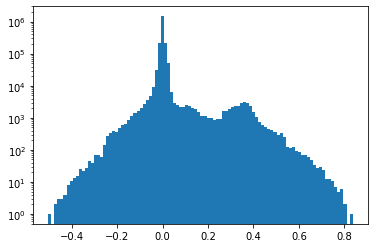

In [34]:
plt.hist(tensor2np(style_vector_volumes[batch_index]).flatten(), bins = 100)
plt.yscale('log', nonposy='clip')
plt.show()

# V2V forward pass

In [35]:
# style_vectors_list = []
# gamma_vectors_list = []
# beta_vectors_list = []
# input_vectors_list = []
# outout_vectors_list = []
# params_vectors_list = []

# class Trace:
#     def __init__(self, name):
#         self.name = name

#     def __call__(self,module, input, output):
#         x, style_vec,_ = input
#         params = F.interpolate(style_vec, size=x.size()[2:], mode='trilinear')
#         actv = module.shared(params)
#         gamma = module.gamma(actv)
#         beta = module.beta(actv)

#         out = module.bn(x) * (1 + gamma) + beta
#         if not output.isclose(out).all():
#             set_trace()
#         global style_vectors_list
#         style_vectors_list += [style_vec]
#         global params_vectors_list
#         params_vectors_list += [params]
#         global gamma_vectors_list
#         gamma_vectors_list += [1+gamma]
#         global beta_vectors_list
#         beta_vectors_list += [beta]
#         global input_vectors_list
#         input_vectors_list += [x]
#         global outout_vectors_list
#         outout_vectors_list += [out]

# # establish hook
# handles = []
# for name, module in model.named_modules():
#     if 'adaptive_norm' == name.split('.')[-1]:
#         handles.append(module.register_forward_hook(Trace(name)))
    
# # forward pass
# i = 150
# eval_view = 0 
# batch = val_loader.dataset.__getitem__(i + eval_view*val_loader.dataset.n_sequences)

# batch = collate_fn([batch])
# (images_batch, 
# keypoints_3d_gt, 
# keypoints_3d_validity_batch_gt,  
# proj_matricies_batch) = dataset_utils.prepare_batch(batch, device)
# out = model(images_batch, batch)

# # remove hooks
# for handle in handles:
#     handle.remove()

In [36]:
# L = len(style_vectors_list)
# batch_index = 0

# tensors_dict = {'style':style_vectors_list,
#                 'gamma (mult)':gamma_vectors_list,
#                 'beta (add)':beta_vectors_list,
#                 'x':input_vectors_list,
#                 'out':outout_vectors_list,
#                 'params':params_vectors_list}

# indexes = range(0,L,2)
# fig, axes = plt.subplots(nrows = len(tensors_dict), ncols = len(indexes), figsize=(100,50))

# for i,name in enumerate(tensors_dict.keys()):
#     for j,index in enumerate(indexes):
#         tensor = tensors_dict[name][index].detach().cpu().numpy()[batch_index]
#         axes[i,j].hist(tensor.flatten(), bins=100)
#         axes[i,j].set_yscale('log', nonposy='clip')
#         axes[i,j].set_title(name)
# plt.show()

# Decoding

In [37]:
########################## 
# VOLUMES FEEDING TO V2V #   
##########################         
if self.temporal_condition_type == 'adain':
    volumes = self.volume_net(unproj_features, params=style_vector)
elif self.temporal_condition_type == 'spade':       
    volumes = self.volume_net(unproj_features, params=style_vector_volumes)
elif self.temporal_condition_type == 'stack':
    volumes = self.volume_net(torch.cat([unproj_features, style_vector_volumes], 1))
else:
    raise RuntimeError('Wrong self.temporal_condition_type, should be in [`adain`, `stack`, `spade`]')    

# integral 3d
vol_keypoints_3d, volumes = integrate_tensor_3d_with_coordinates(volumes * self.volume_multiplier,
                                                                 coord_volumes,
                                                                 softmax=self.volume_softmax)
print ('Done')    

Done


/media/hpc2_storage/ibulygin/miniconda3/envs/mvn/lib/python3.6/site-packages/torch/nn/functional.py:2479: UserWarning:

Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.



In [38]:
#####################
# FEATURES DECODING #   
#####################  
decoded_features = None
if self.use_style_decoder:
    if self.style_decoder_type == 'v2v':
        decoded_features = self.style_decoder(style_vector)
        decoded_features = torch.transpose(decoded_features,1,2)
    elif self.style_decoder_type == 'lstm':
        decoded_features = self.style_decoder(style_vector,
                                              original_pivot_features)
print ('Done')     

Done


In [39]:
       
#####################
# STYLE - POSE LOSS #   
#####################  
if self.use_style_pose_lstm_loss:
    time=lstm_coord_volumes.shape[1]
    assert time == dt//2

    if self.use_style_volume_for_SPL:
        lstm_volumes = self.style_pose_lstm_loss_decoder(style_vector_volumes, volumes, time=time)
    elif self.use_style_me_for_SPL:
        lstm_volumes = self.style_pose_lstm_loss_decoder(style_vector_me, volumes, time=time)
    else:    
        lstm_volumes = self.style_pose_lstm_loss_decoder(style_vector, volumes, time=time)

    lstm_volumes = lstm_volumes.view(-1, *lstm_volumes.shape[2:])
    lstm_coord_volumes = lstm_coord_volumes.view(-1, *lstm_coord_volumes.shape[2:])
    lstm_keypoints_3d, _ = integrate_tensor_3d_with_coordinates(lstm_volumes * self.volume_multiplier,
                                                                lstm_coord_volumes,
                                                                softmax=self.volume_softmax)

    lstm_keypoints_3d = lstm_keypoints_3d.view(batch_size, time, *lstm_keypoints_3d.shape[1:])
    vol_keypoints_3d = [vol_keypoints_3d, lstm_keypoints_3d]
print ('Done')        

Done


# Grid

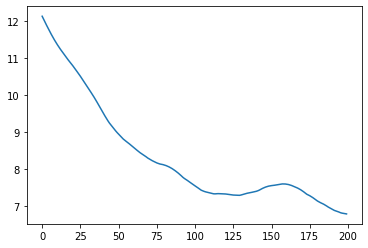

In [46]:
coord_volumes_opt = coord_volumes.clone().detach().cpu().requires_grad_(True)
keypoints_3d_gt = keypoints_3d_gt.clone().detach().cpu().requires_grad_(False)
volumes_opt = volumes.clone().detach().cpu().requires_grad_(False)
opt = torch.optim.Adam([coord_volumes_opt], lr=1e-1)

losses = []
for i in tqdm_notebook(range(200)):
    
    vol_keypoints_3d_opt = torch.einsum("bnxyz, bxyzc -> bnc", volumes_opt, coord_volumes_opt)
    
    L = torch.sqrt((vol_keypoints_3d_opt - keypoints_3d_gt)**2).mean()
    L.backward()
    opt.step()
    losses.append(L.item())
plt.plot(losses)    

In [59]:
d = 5
coord_volumes_vis = coord_volumes[0, 0:30:d, 0:30:d, 5:30:d,...].contiguous()
coord_volumes_vis_2 = coord_volumes_opt.cpu()[0, 0:30:d, 0:30:d, 5:30:d,...].contiguous()

In [60]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
import plotly.graph_objs as go
import colorlover as cl

coords = coord_volumes_vis.view(-1, 3).detach().cpu().numpy()
coords2 = coord_volumes_vis_2.view(-1, 3).detach().cpu().numpy()

keypoints = vol_keypoints_3d.view(-1, 3).detach().cpu().numpy()
keypoints2 = vol_keypoints_3d_opt.view(-1, 3).detach().cpu().numpy()

init_notebook_mode(connected=False)  
color_grid = cl.scales['10']['div']['RdYlBu'][0]
color_kp = cl.scales['10']['div']['RdYlBu'][-1]
plotly_data = []

grid = dict(x = coords[:,0],
            y = coords[:,1],
            z = coords[:,2],
            type = "scatter3d",    
            mode = 'markers',
            marker = dict(size=5,
                          color=color_grid,
                          line=dict(width=0)))
plotly_data.append(grid)

# 
grid2 = dict(x = coords2[:,0],
            y = coords2[:,1],
            z = coords2[:,2],
            type = "scatter3d",    
            mode = 'markers',
            marker = dict(size=5,
                          color='orange',
                          line=dict(width=0)))
plotly_data.append(grid2)


# connections
connectivity = CONNECTIVITY_DICT['human36m']
for (index_from, index_to) in connectivity:
    xs, ys, zs = [np.array([keypoints[index_from, j], keypoints[index_to, j]]) for j in range(3)]

    plotly_data.append(go.Scatter3d(x=xs, y=ys, z=zs,
                         marker=dict(size=4,color='green'),
                         line=dict(color='green',width=2)))
    
# connections
connectivity = CONNECTIVITY_DICT['human36m']
for (index_from, index_to) in connectivity:
    xs, ys, zs = [np.array([keypoints2[index_from, j], keypoints2[index_to, j]]) for j in range(3)]

    plotly_data.append(go.Scatter3d(x=xs, y=ys, z=zs,
                         marker=dict(size=4,color='blue'),
                         line=dict(color='blue',width=2)))    


fig = go.Figure(data=plotly_data)
iplot(fig, show_link = False)

In [64]:
keypoints_3d_gt = keypoints_3d_gt.cpu()
vol_keypoints_3d = vol_keypoints_3d.detach().cpu()
torch.sqrt((vol_keypoints_3d - keypoints_3d_gt)**2).mean(), torch.sqrt((vol_keypoints_3d_opt - keypoints_3d_gt)**2).mean()

(tensor(12.1319), tensor(6.7946, grad_fn=<MeanBackward0>))

# Helper functions


In [30]:
labels=val_loader.dataset.labels
start_frame_indexes, stop_frame_indxs=get_start_stop_frame_indxs(labels)

### define ###
length=500
action = 'Directions-1'
subject = 'S9'
camera_index = 0
##############

action_index=retval['action_names'].index(action)
offset = len(retval['action_names']) if subject == 'S11' else 0
start=start_frame_indexes[offset:][action_index].item()

assert subject in ['S9', 'S11']
assert subject, action == index_to_name(start+length, stop_frame_indxs)

# Collect keypoints from multiview

In [31]:
USE_RANDOM_STYLE_VECTOR = True
USE_CONSTANT_STYLE_VECTOR = True

RETURN_DECODED_FEATUES = False
RETURN_ME_VECTOR = False

ADD_STYLE_VECTORS = True
ADD_IMAGES = False
ADD_UNPROJ_FEATURES = False

SPL = model.use_style_pose_lstm_loss

KIND = model.kind
series = defaultdict(list)
series['images'] = defaultdict(list)
series['proj_matrices'] = defaultdict(list)
eval_view = 0 # supported [0,1,2,3] cameras

# for i in range(10):
    
#     ### define ###
#     length=100
#     action = np.random.choice(retval['action_names'], 1)[0]
#     subject = np.random.choice(['S9', 'S11'], 1)[0]
#     camera_index = 0
#     ##############
    
    
    
#     if i == 0:
#         print (subject, action)

#     action_index=retval['action_names'].index(action)
#     offset = len(retval['action_names']) if subject == 'S11' else 0
#     start=start_frame_indexes[offset:][action_index].item()

#     assert subject in ['S9', 'S11']
#     assert subject, action == index_to_name(start+length, stop_frame_indxs)
    
model.eval()
with torch.no_grad():
    for i in tqdm_notebook(range(start,start+length)):
        ##############
        # EVALUATION #
        ##############
        batch = val_loader.dataset.__getitem__(i + eval_view*val_loader.dataset.n_sequences)
        if batch is None:
            print('Batch is none...')
            break
        
        batch = collate_fn([batch])
        (images_batch, 
        keypoints_3d_gt, 
        keypoints_3d_validity_batch_gt, 
        proj_matricies_batch) = dataset_utils.prepare_batch(batch, device)

        output = model(images_batch, batch, return_me_vector=RETURN_ME_VECTOR)
        torch.cuda.empty_cache()

        if USE_RANDOM_STYLE_VECTOR:
            randomized_output = model(images_batch, batch, randomize_style=True)
            torch.cuda.empty_cache()

        if USE_CONSTANT_STYLE_VECTOR:
            const_output = model(images_batch, batch, const_style_vector=True)
            torch.cuda.empty_cache()    

        if SPL:
            for i in range(dt//2):
                series[f'gt_future_keypoints_{i}'] = keypoints_3d_gt[:,pivot_position+1+i].detach().cpu().numpy()
                series[f'predicted_future_keypoints_{i}'] = output[0][1][:,i].detach().cpu().numpy()
            keypoints_3d_gt = keypoints_3d_gt[:,pivot_position]
            keypoints_3d_pred = output[0][0]
        else:
            keypoints_3d_gt = keypoints_3d_gt
            keypoints_3d_pred = output[0]

        if RETURN_DECODED_FEATUES:
            series['decoded_features'].append(output[-1].detach().cpu().numpy())
            series['features_for_loss'].append(output[1].detach().cpu().numpy())

        if RETURN_ME_VECTOR and ADD_STYLE_VECTORS:
            series['style_vectors'].append(output[-3][0].detach().cpu().numpy())
            series['style_vectors_me'].append(output[-3][1].detach().cpu().numpy())

        else:
            if ADD_STYLE_VECTORS:
                series['style_vectors'].append(output[-3].detach().cpu().numpy())
        if ADD_UNPROJ_FEATURES:
            series['unproj_features'].append(output[-2].detach().cpu().numpy())

        keypoints_3d_pred_const_style = const_output[0][0] if SPL else const_output[0]
        keypoints_const_style = keypoints_3d_pred_const_style.detach().cpu().numpy()
        series['keypoints_const_style'].append(keypoints_const_style)
        if ADD_STYLE_VECTORS:
            series['style_vectors_const'].append(const_output[-3].detach().cpu().numpy())

        keypoints_3d_pred_random_style = randomized_output[0][0] if SPL else randomized_output[0]
        keypoints_random_style = keypoints_3d_pred_random_style.detach().cpu().numpy()
        series['keypoints_random_style'].append(keypoints_random_style)

        batch_size, n_views, n_joints = keypoints_3d_gt.shape[:3]

        # normalize all stuff
        proj_matricies_batch = proj_matricies_batch[:,pivot_position].detach().cpu().numpy()
        images_batch = normalize_temporal_images_batch(images_batch, pivot_position)
        keypoints = keypoints_3d_pred.detach().cpu().numpy()
        keypoints_gt =  keypoints_3d_gt.detach().cpu().numpy()

        series['keypoints'].append(keypoints)
        series['keypoints_gt'].append(keypoints_gt)

        if ADD_IMAGES:
            series['images'][eval_view].append(images_batch)
            series['proj_matrices'][eval_view].append(proj_matricies_batch)

        ##############
        # PROJECTING #
        ##############
        if ADD_IMAGES:
            for view_i in range(4):
                if view_i == eval_view:
                    continue
                else:
                    batch = val_loader.dataset.__getitem__(i + view_i*val_loader.dataset.n_sequences)
                    batch = collate_fn([batch])

                    (images_batch, 
                    keypoints_3d_gt, 
                    keypoints_3d_validity_batch_gt, 
                    proj_matricies_batch) = dataset_utils.prepare_batch(batch, device)

                    # normalize all stuff
                    proj_matricies_batch = proj_matricies_batch[:,pivot_position].detach().cpu().numpy()
                    images_batch = normalize_temporal_images_batch(images_batch, pivot_position)

                    series['images'][view_i].append(images_batch)
                    series['proj_matrices'][view_i].append(proj_matricies_batch)

/media/hpc2_storage/ibulygin/miniconda3/envs/mvn/lib/python3.6/site-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


STYLE_VECTOR_CONST INITED


/nfs/hpc2_storage/ibulygin/learnable-triangulation-pytorch/mvn/models/volumetric_adain.py:460: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  style_vector = torch.tensor(self.STYLE_VECTOR_CONST).to(device)


In [32]:
for k in series.keys():
    if isinstance(series[k], list):
        series[k] = np.concatenate(series[k],0)         
    elif isinstance(series[k], dict):
        for sub_k in series[k].keys():
            series[k][sub_k] = np.concatenate(series[k][sub_k],0) 

In [56]:
# for k in series.keys():
#     print (k, series[k].shape)

In [17]:
# def shuffle(style_vector):
#     idx = torch.randperm(style_vector.nelement())
#     return style_vector.view(-1)[idx].view(style_vector.size())
# l1= torch.tensor(series['style_vectors'][0])
# l2=torch.tensor(series['style_vectors'][0])
# torch.norm(l1 -shuffle(l2)).mean()*1e-4

In [18]:
# x = torch.randn(3,3).requires_grad_()
# W = torch.randn(3,3).requires_grad_()
# y = torch.randn(3,3).requires_grad_()
# c = W@x
# z = y
# # c=c.detach()
# s = c + z
# (s.norm()+1).backward()
# W.grad

In [33]:
# check const-style-vectors
if USE_CONSTANT_STYLE_VECTOR:
    flag = []
    for i in range(length):
        for j in range(length): 
            flag += [(series['style_vectors_const'][j] == series['style_vectors_const'][i]).all()]
    print (all(flag)) 

True


In [20]:
# style_vector = torch.tensor(series['style_vectors'][0]).cuda().unsqueeze(0)
# next_features = torch.tensor(series['features_for_loss'][0]).cuda().unsqueeze(0)
# pred_features = model.style_decoder(style_vector)

# fig, axes = plt.subplots(ncols=5, nrows=10)
# for i,c in enumerate(np.random.choice(np.arange(256), 10)):
#     for j in range(5):
#         axes[i,j].imshow(pred_features[0,c,j].detach().cpu().numpy())
# fig, axes = plt.subplots(ncols=5, nrows=10)
# for i,c in enumerate(np.random.choice(np.arange(256), 10)):
#     for j in range(5):
#         axes[i,j].imshow(next_features[0,j,c].detach().cpu().numpy())

In [21]:
# fig, axes = plt.subplots(ncols=32, nrows=32, figsize=(100,100))
# for i in range(32):
#     for j in range(32):
#         axes[i,j].imshow(series['unproj_features'][0][i,j])
#         axes[i,j].set_xticks([])
#         axes[i,j].set_yticks([])

In [22]:
# for joint in range(17):
#     diffs_model = []
#     diffs_gt = []
#     diffs_rand = []
    
#     for i in range(1, length):
#         diffs_model.append(np.linalg.norm(series['keypoints'][i,joint] - np.linalg.norm(series['keypoints'][i-1,joint])))
#         diffs_gt.append(np.linalg.norm(series['keypoints_gt'][i,joint] - np.linalg.norm(series['keypoints_gt'][i-1,joint])))
#         diffs_rand.append(np.linalg.norm(series['keypoints_random_style'][i,joint] - np.linalg.norm(series['keypoints_random_style'][i-1,joint])))
        
#     plt.figure()
#     plt.plot(diffs_model, label = 'diffs_model')
#     plt.plot(diffs_gt, label = 'diffs_gt')
#     plt.plot(diffs_rand, label = 'diffs_rand')
                          
#     plt.title(f'Joint: {joint}')
#     plt.legend()

# Plot error

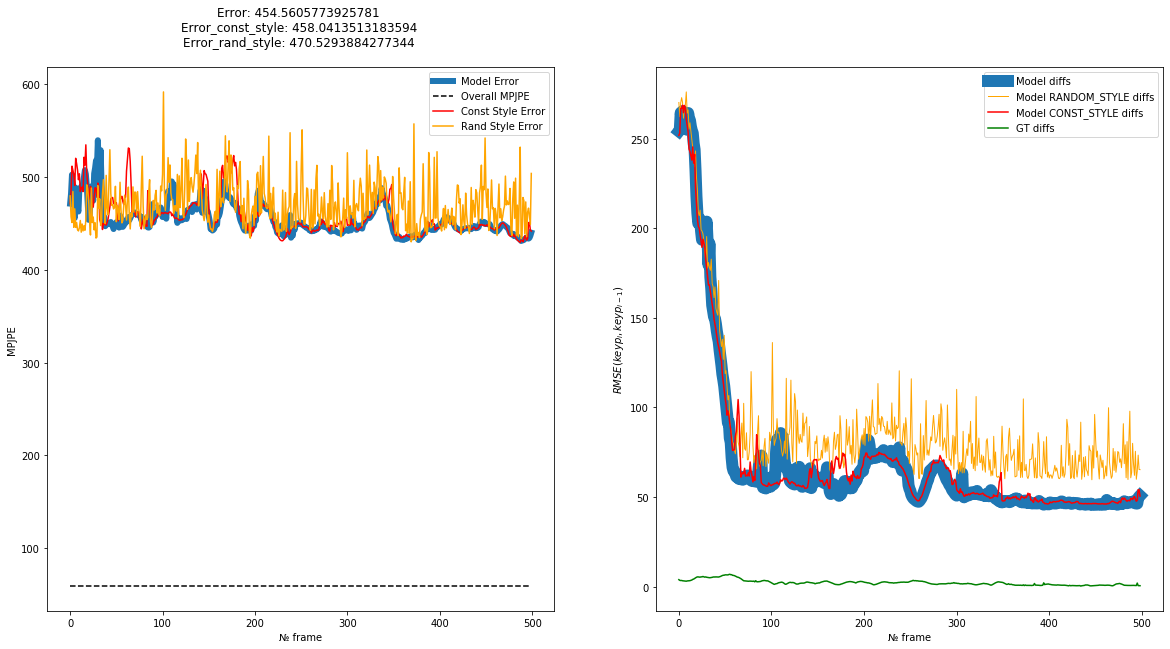

In [34]:
MPJPE = 59
#########
# ERROR #   
#########
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20,10))
error, gt_diffs, model_diffs = get_error_diffs(series['keypoints_gt'], series['keypoints'])
ax1.plot(error, label='Model Error', linewidth=6)
if MPJPE is not None:
    ax1.plot([MPJPE]*len(error), '--', color='black', label='Overall MPJPE')

title = f"Error: {error.mean()} \n"

if USE_CONSTANT_STYLE_VECTOR:
    error_const_style, _, model_diffs_const_style = get_error_diffs(series['keypoints_gt'], series['keypoints_const_style'])
    ax1.plot(error_const_style, 'red', label='Const Style Error')
    title += f"Error_const_style: {error_const_style.mean()} \n"

if USE_RANDOM_STYLE_VECTOR:
    error_rand_style, _, model_diffs_rand_style = get_error_diffs(series['keypoints_gt'], series['keypoints_random_style'])
    ax1.plot(error_rand_style, 'orange', label='Rand Style Error')
    title += f"Error_rand_style: {error_rand_style.mean()} \n"

ax1.set_xlabel('№ frame')
ax1.set_ylabel('MPJPE')
ax1.set_title(title)
ax1.legend()

#########
# DIFFS #   
#########
ax2.plot(model_diffs, label='Model diffs', linewidth=12)

if USE_RANDOM_STYLE_VECTOR:
    ax2.plot(model_diffs_rand_style, 'orange',label='Model RANDOM_STYLE diffs', linewidth=1)
if USE_CONSTANT_STYLE_VECTOR:
    ax2.plot(model_diffs_const_style, 'red',label='Model CONST_STYLE diffs')    

ax2.plot(gt_diffs, 'g', label='GT diffs')
ax2.set_xlabel('№ frame')
ax2.set_ylabel(r'$RMSE(keyp_{i}, keyp_{i-1})$')
ax2.legend()

In [24]:
# plt.figure()
# plt.plot(error)
# plt.plot(error_const_style, 'red')

In [25]:
# class SPADE2D(nn.Module):
#     def __init__(self, style_vector_channels, features_channels, hidden=128, ks=3): #  hidden=128
#         super().__init__()

#         pw = ks // 2
#         self.shared = nn.Sequential(
#             nn.Conv2d(style_vector_channels, hidden, kernel_size=ks, padding=pw),
#             nn.LeakyReLU()
#         )
#         self.gamma = nn.Conv2d(hidden, features_channels, kernel_size=ks, padding=pw)
#         self.beta = nn.Conv2d(hidden, features_channels, kernel_size=ks, padding=pw)
#         self.bn = nn.BatchNorm2d(features_channels, affine=False, track_running_stats=False)

#     def forward(self, x, params):

#         params = F.interpolate(params, size=x.size()[2:], mode='nearest')
#         actv = self.shared(params)
#         gamma = self.gamma(actv)
#         beta = self.beta(actv)
#         out = self.bn(x) * (1 + gamma) + beta
#         return out, gamma, beta

In [26]:
# images_names = list(filter(lambda x: re.search('image', x) is not None, os.listdir('./test_images/')))
# style_names = list(filter(lambda x: re.search('style', x) is not None, os.listdir('./test_images/')))
# N = len(images_names)
# transforms = Compose([Resize((256,256)), ToTensor()])

# image_tensors = []
# style_tensors = []

# fig, axes = plt.subplots(nrows=N, ncols=3, figsize=(30,30))

# for i, (image_name, style_name) in enumerate(zip(images_names, style_names)):
#     pil_image = Image.open(os.path.join('./test_images', image_name))
#     pil_style = Image.open(os.path.join('./test_images', style_name))
    
#     img_tensor = transforms(pil_image)
#     style_tensor = transforms(pil_style)

#     spade = SPADE2D(3,3)
#     img_spade, _, _ = spade(img_tensor.unsqueeze(0), style_tensor.unsqueeze(0))
#     img_spade = img_spade.squeeze(0)
    
#     style_tensors.append(style_tensor)
#     image_tensors.append(img_tensor)
    
#     axes[i,0].imshow(img_tensor.unsqueeze(-1).transpose(0,3)[0].detach().numpy())
#     axes[i,1].imshow(style_tensor.unsqueeze(-1).transpose(0,3)[0].detach().numpy())
#     axes[i,2].imshow(img_spade.unsqueeze(-1).transpose(0,3)[0].detach().numpy())

In [27]:
# spade = SPADE2D(3,3)
# img_spade, gamma, beta = spade(image_tensors[0].unsqueeze(0), image_tensors[1].unsqueeze(0))
# img_bn = spade.bn(image_tensors[0].unsqueeze(0)).squeeze(0)
# img_spade = img_spade.squeeze(0)
# gamma = (1+gamma).squeeze(0)
# beta = beta.squeeze(0)

# plt.figure()
# plt.imshow(img_spade.unsqueeze(-1).transpose(0,3)[0].detach().numpy())
# plt.figure()
# plt.imshow(img_bn.unsqueeze(-1).transpose(0,3)[0].detach().numpy())
# plt.figure()
# plt.imshow(gamma.unsqueeze(-1).transpose(0,3)[0].detach().numpy())
# plt.figure()
# plt.imshow(beta.unsqueeze(-1).transpose(0,3)[0].detach().numpy())

# Debug

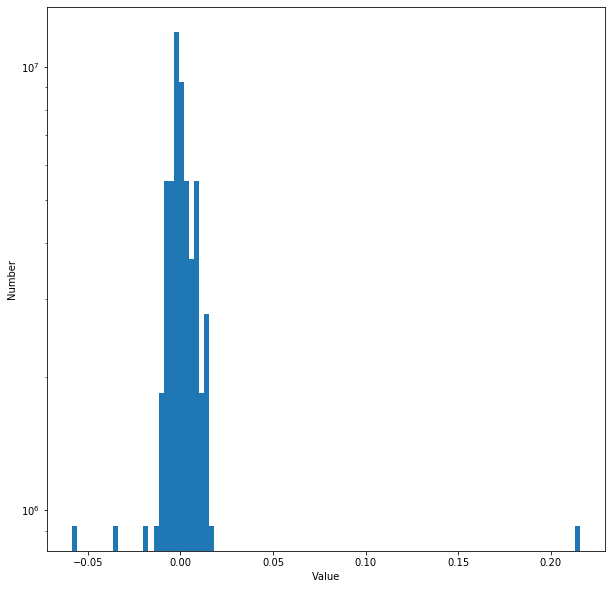

In [28]:
style_vectors = series['style_vectors']#.squeeze(1)
style_vectors_me = series['style_vectors_me']#.squeeze(1)

unproj_features = series['unproj_features']
plt.figure(figsize=(10,10))
plt.hist(style_vectors.flatten(), bins=100)
plt.yscale('log', nonposy='clip')
plt.xlabel('Value')
plt.ylabel('Number')

# plt.show()
# plt.close('all')
plt.savefig(f"{os.path.join(experiment_root, 'hist')}", dpi=280)

IndexError: index 100 is out of bounds for axis 0 with size 100

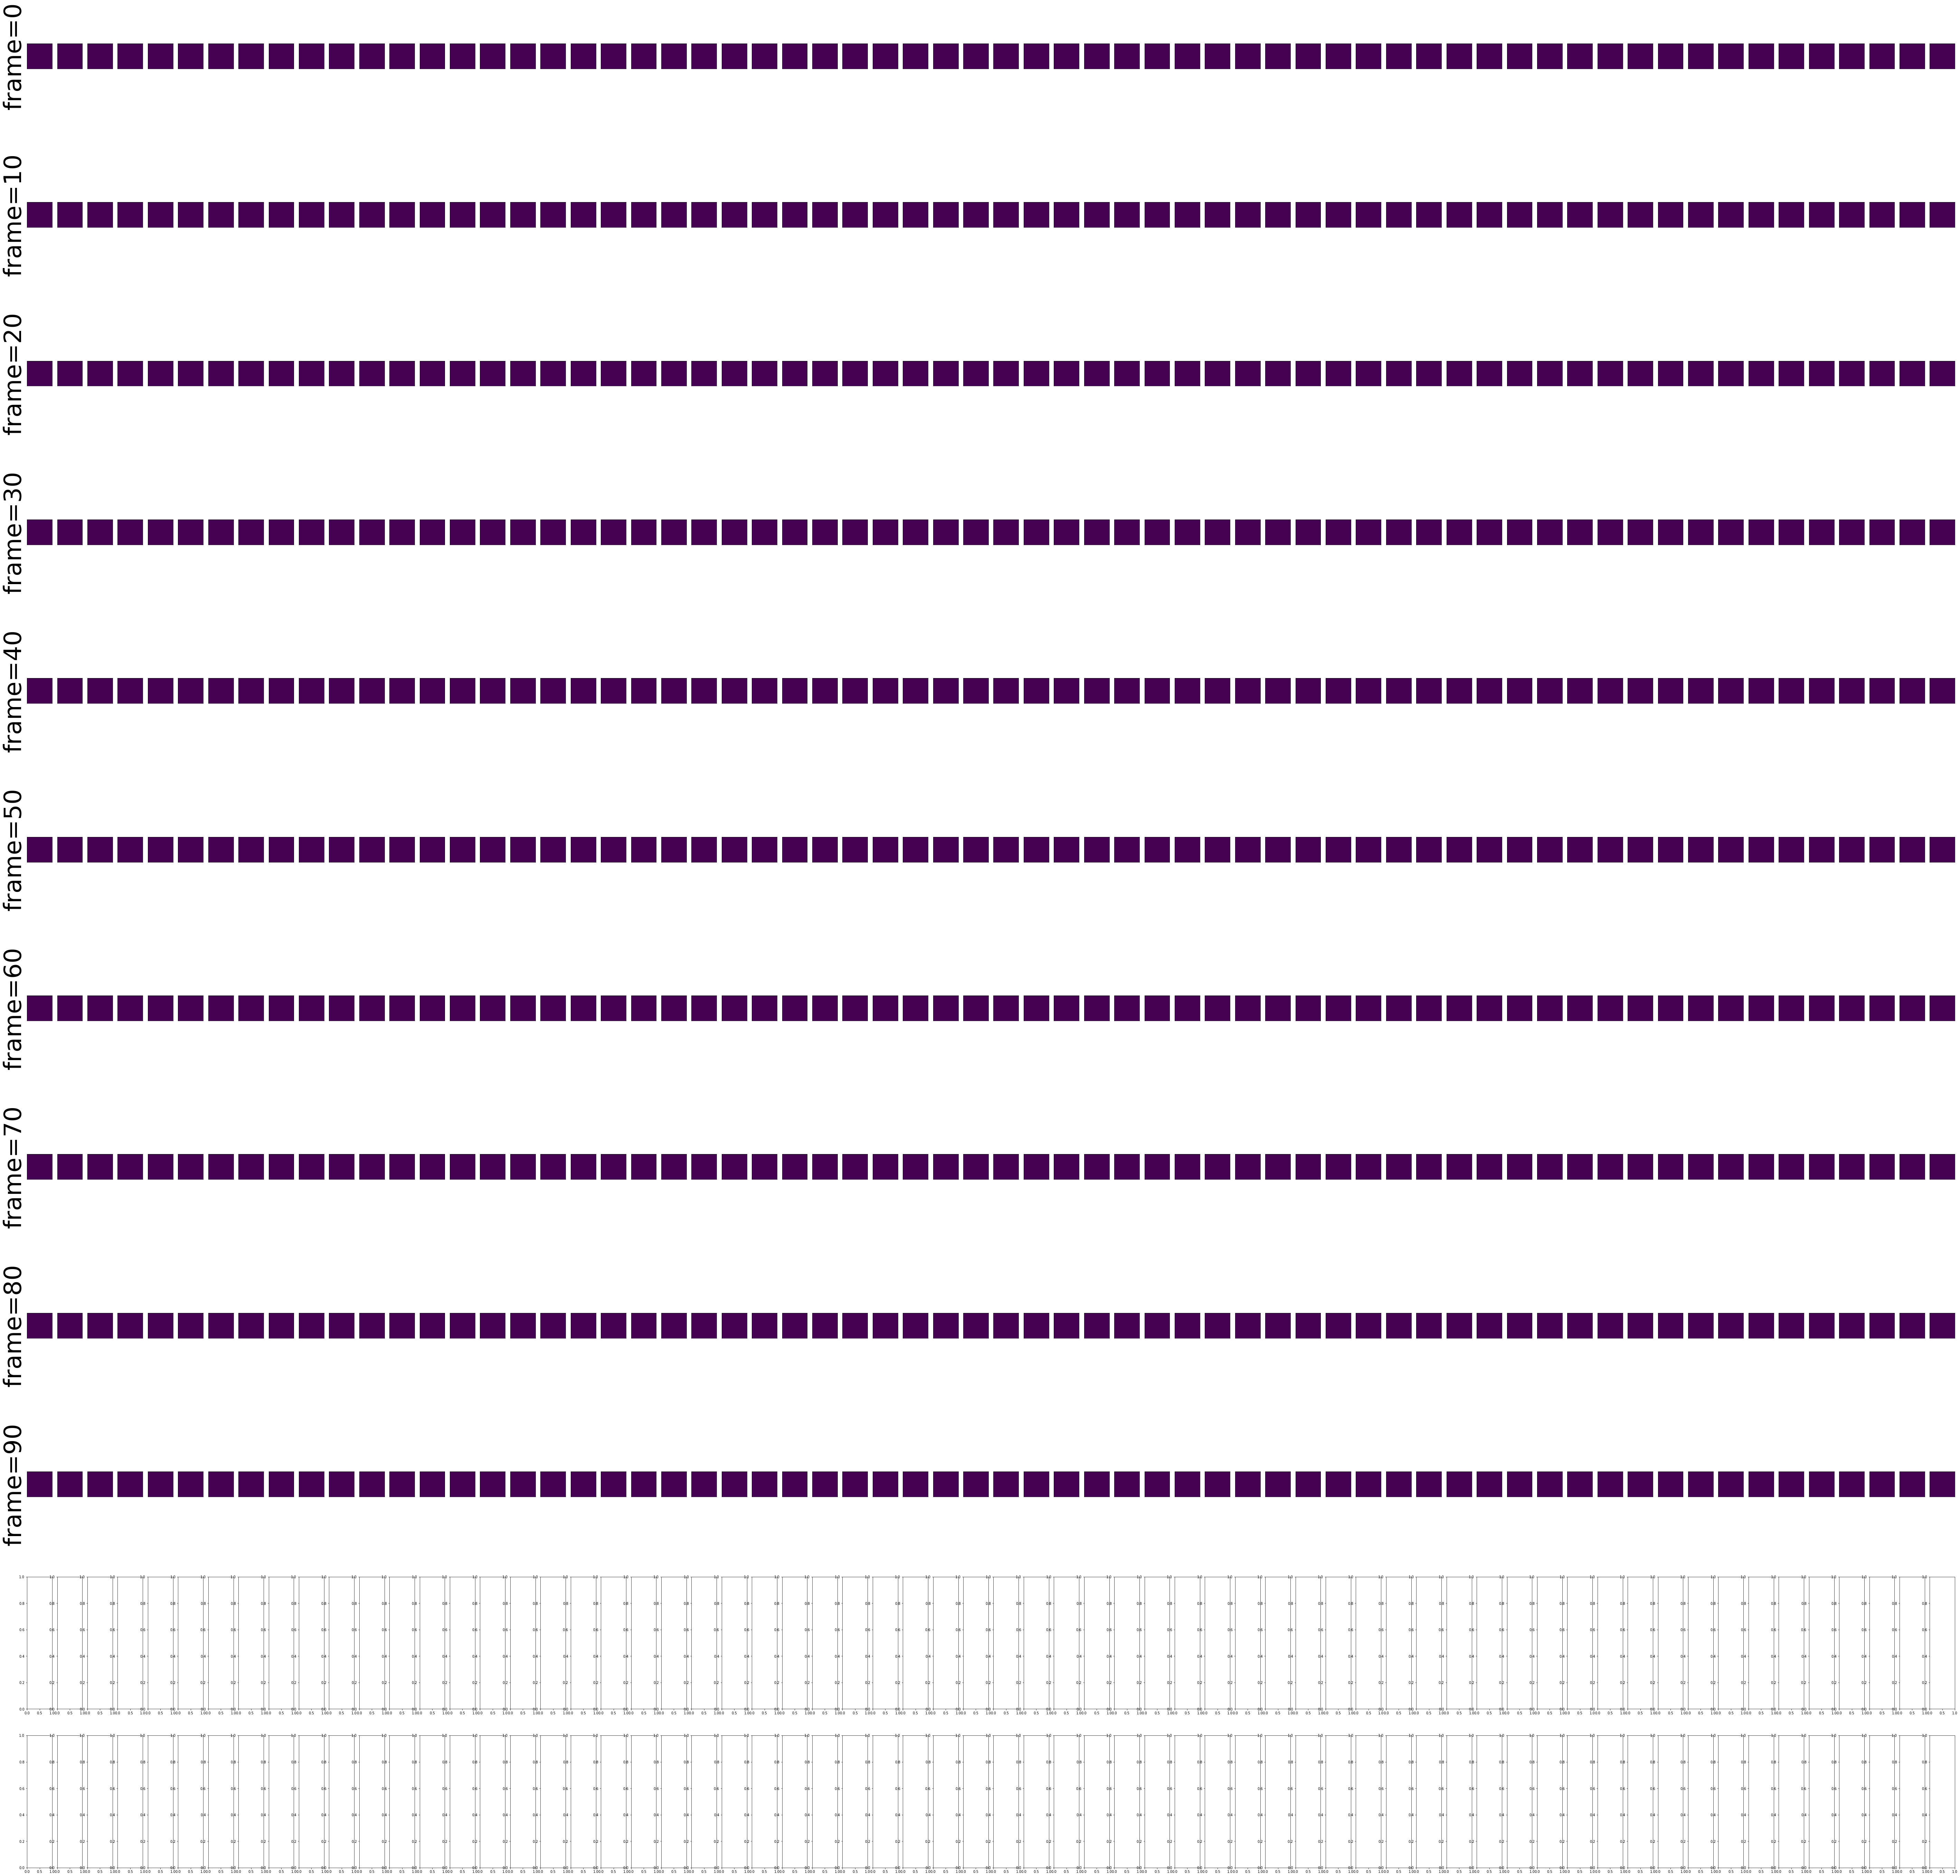

In [30]:
if series['style_vectors'].ndim == 2:
    plt.imshow(series['style_vectors'])
    plt.xlabel('feature index')
    plt.ylabel(r'$\leftarrow$№ frame')

elif series['style_vectors'].ndim == 4:
    n_frames = 12
    dilation = 10
#     style_channel = np.argmax([style_vectors[:,i,...].reshape(length, -1).ptp(0).max() \
#                                for i in range(style_vectors.shape[-3])])
    n_style_channels = style_vectors.shape[-3]
    fig, axes = plt.subplots(ncols=n_style_channels,
                             nrows=n_frames,
                             figsize=(100,100))
    for i in range(n_frames):
        for j in range(n_style_channels):
            t = i*dilation
            axes[i,j].imshow(style_vectors[t, j])
            axes[i,j].set_xticks([])
            axes[i,j].set_yticks([])
            if j == 0:
                axes[i,j].set_ylabel(f'frame={t}', fontsize=70)
    fig.subplots_adjust(hspace=0., wspace=0.)
    fig.suptitle('Style-Tensor feature-maps', fontsize=100, y = 0.9)
    plt.show()    
        
elif series['style_vectors'].ndim == 5:
    style_channel = np.argmax([style_vectors[:,i,...].reshape(length, -1).ptp(0).max() \
                               for i in range(style_vectors.shape[-3])])
    ptp = style_vectors[:, style_channel].reshape(length, -1).ptp(0).max()
    n_frames = 12
    dilation = 2
    n_style_channels = style_vectors.shape[-4]
    time_dimension = style_vectors.shape[-3]
    n = int(np.sqrt(n_style_channels))
    fig, axes = plt.subplots(ncols=time_dimension,
                             nrows=n_frames,
                             figsize=(100,100))
    for i in range(n_frames):    
        for j in range(time_dimension):
            t = i*dilation
            axes[i,j].imshow(style_vectors[t, style_channel, j])
            axes[i,j].set_xticks([]) 
            axes[i,j].set_yticks([])
            if j == 0:
                axes[i,j].set_ylabel(f'frame={t}', fontsize=70)
    fig.subplots_adjust(hspace=0., wspace=0.)
    fig.suptitle(f'Style-Tensor slices along first spatial dimension, with channel that gives maximal PTP={np.round(ptp,4)}', fontsize=100, y = 0.9)
    plt.show()
        

In [ ]:
ptp = style_vectors.reshape(length, -1).ptp(0)
var = style_vectors.reshape(length, -1).var(0)

In [ ]:
plt.plot(ptp)
plt.title(f'PTP mean: {ptp.mean()}')
plt.ylabel('mean ptp over time')
plt.xlabel('feature index')

In [ ]:
plt.plot(var)
plt.title(f'VAR mean: {var.mean()}')
plt.ylabel('mean variance over time')
plt.xlabel('feature index')


In [ ]:
style_diffs = []
style_diffs_me = []
dilation = 1
for i in range(dilation,length):
    style_diffs.append(np.linalg.norm(style_vectors[i] - style_vectors[i-dilation]))
#     style_diffs_me.append(np.linalg.norm(style_vectors_me[i] - style_vectors_me[i-dilation]))
plt.plot(style_diffs) 
# plt.plot(style_diffs_me, 'r') 
plt.xlabel('№ frame')
plt.ylabel(r'$||s(t_i) - s(t_{i-1}) ||$')


In [ ]:
# i_max = range(dilation,length)[np.argmin(style_diffs)] 
# diff = style_vectors[i_max] - style_vectors[i_max-1] 

In [ ]:
# nrows = 5
# fig, axes = plt.subplots(ncols=diff.shape[1],
#                              nrows=nrows,
#                              figsize=(100,100))
# for i in range(nrows):    
#     for j in range(diff.shape[1]):
#         axes[i,j].imshow(diff[i,j])
#         axes[i,j].set_xticks([])
#         axes[i,j].set_yticks([])
# plt.show()

In [ ]:
# fig, axes = plt.subplots(ncols=8,
#                              nrows=8,
#                              figsize=(100,100))

# for i in range(8):
#     for j in range(8):
#         axes[i,j].imshow(w1_flat_dim[:,i*8 + j,...])
#         axes[i,j].set_xticks([])
#         axes[i,j].set_yticks([])

In [ ]:
# for v in d['weight']:
#     plt.figure()
#     plt.hist(v.flatten(),bins=100)
# plt.show()    

# Post processing

In [ ]:
# from scipy.signal import savgol_filter, savgol_coeffs
# n_joints = series['keypoints'].shape[1]
# series['keypoints_smoothed'] = []
# for i in range(n_joints):
#     joint_coord_sequence = series['keypoints'][:,i]
#     series['keypoints_smoothed'] += [savgol_filter(joint_coord_sequence, window_length=25, polyorder = 2, axis=0)]
# series['keypoints_smoothed'] = np.stack(series['keypoints_smoothed'], 1)

In [ ]:
# coord=1
# joint = 3
# plt.plot(series['keypoints_smoothed'][:,joint,coord][:20],'r', label='smoothed')
# plt.plot(series['keypoints'][:,joint,coord][:20], label='original')
# plt.legend()

# Make Video

In [ ]:
# video_path = os.path.join('videos/',experiment_type, experiment_name)
# if not os.path.isdir(video_path):
#     os.makedirs(video_path)
#     print ('video_path - Created')
# else:
#     print ('video_path - Already exists')
    
# keypoints_dir = os.path.join(video_path,'{0}_{1}'.format(subject, action),'keypoints_videos_lowres')
# if not os.path.isdir(keypoints_dir):
#     os.makedirs(keypoints_dir)
#     print ('keypoints_dir - Created')
# else:
#     print ('keypoints_dir - Already exists')        

In [ ]:
# with_gt = True
# with_random_style = True
# add_per_joint_description = False
# for i in tqdm_notebook(range(1)):
#     fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (45,45))
#     for view in range(4):

#         # unpack
#         image = series['images'][view][i]
#         proj_matrice = series['proj_matrices'][view][i]
#         keypoints_3d_gt = series['keypoints_gt'][i]
#         keypoints_3d_pred = series['keypoints'][i] #if not with_random_style else series['keypoints_random_style'][i]

#         ax_i = ax.flatten()[view]
#         ax_i.imshow(image)

#         pjpe = np.linalg.norm(keypoints_3d_gt - keypoints_3d_pred, axis=-1)

#         # predicted keypoints
#         keypoints_2d_pred_proj = project_3d_points_to_image_plane_without_distortion(proj_matrice,
#                                                                                     keypoints_3d_pred)
#         draw_2d_pose(keypoints_2d_pred_proj,ax_i,kind='human36m', point_size=200, line_width=5)

#         if with_gt:
#             keypoints_2d_gt_proj = project_3d_points_to_image_plane_without_distortion(proj_matrice,
#                                                                                         keypoints_3d_gt)
#             draw_2d_pose(keypoints_2d_gt_proj, ax_i,kind='human36m', point_size=200, line_width=5, color='g')

#         if view == eval_view and add_per_joint_description:
#             ax_i.set_title(f'EVAL_VIEW, MPJPE: {pjpe.mean()}', fontsize=34)
#             text = ''.join([j_name + f': ~{int(pjpe[j_n])}' + '\n' for j_n,j_name in JOINT_H36_DICT.items()])
#             h,w = image.shape[:2]
#             offset_1, offset_2 = 5,10
#             ax_i.text(0+offset_1, h-offset_2, text, style='italic', fontsize=25,
#             bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
#     plt.show()      
# #     plt.savefig('./{}/img_{:05}.jpg'.format(keypoints_dir, i), bbox_inches='tight', dpi=100)
# #     plt.close('all')


# Compare Normal style winth Random style

In [ ]:
# keypoints_3d_pred_original
# keypoints_3d_ranom_style

# plt.fugure()
# # predicted keypoints
# keypoints_2d_pred_proj = project_3d_points_to_image_plane_without_distortion(proj_matrice,
#                                                                             keypoints_3d_pred_original)
# draw_2d_pose(keypoints_2d_pred_proj,ax_i,kind='human36m', point_size=200, line_width=5)

# plt.fugure()
# # predicted keypoints
# keypoints_2d_pred_proj = project_3d_points_to_image_plane_without_distortion(proj_matrice,
#                                                                             keypoints_3d_ranom_style)
# draw_2d_pose(keypoints_2d_pred_proj,ax_i,kind='human36m', point_size=200, line_width=5)

# Compare models video

In [ ]:
# video_path = os.path.join('videos/','baseline_vs_adain')
# if not os.path.isdir(video_path):
#     os.makedirs(video_path)
#     print ('video_path - Created')
# else:
#     print ('video_path - Already exists')
    
# keypoints_dir = os.path.join(video_path,'{0}_{1}'.format(subject, action),'keypoints_videos_lowres')
# if not os.path.isdir(keypoints_dir):
#     os.makedirs(keypoints_dir)
#     print ('keypoints_dir - Created')
# else:
#     print ('keypoints_dir - Already exists')        

In [ ]:
# series_baseline = np.load('action-Directions-1_subj-S9_l100-eval-0_model-vol.npy', allow_pickle=True).item()
# series_model = np.load('action-Directions-1_subj-S9_l100-eval-0_model-vol_temporal_adain.npy', allow_pickle=True).item()
# add_per_joint_description = False

# offset = abs(series_baseline['keypoints_gt'] - series_model['keypoints_gt'][0]).sum(-1).sum(-1).argmin()

# for i in tqdm_notebook(range(20)):

#     fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (45,45))
#     for view in range(4):

#         # unpack
#         image = series_model['images'][view][:-offset][i]
#         proj_matrice = series_model['proj_matrices'][view][:-offset][i]
        
#         keypoints_3d_baseline = series_baseline['keypoints'][offset:][i]
#         keypoints_3d_model = series_model['keypoints'][:-offset][i]
        
#         keypoints_3d_gt_model = series_model['keypoints_gt'][:-offset][i]
#         keypoints_3d_gt_baseline = series_baseline['keypoints_gt'][offset:][i]
        
#         assert (keypoints_3d_gt_model == keypoints_3d_gt_baseline).all()
        
#         ax_i = ax.flatten()[view]
#         ax_i.imshow(image)

#         pjpe_baseline = round(np.linalg.norm(keypoints_3d_gt_baseline - keypoints_3d_baseline, axis=-1).mean(),2)
#         pjpe_model = round(np.linalg.norm(keypoints_3d_gt_model - keypoints_3d_model, axis=-1).mean(),2)
        
#         # predicted keypoints
#         keypoints_2d_baseline_proj = project_3d_points_to_image_plane_without_distortion(proj_matrice,
#                                                                                          keypoints_3d_baseline)
#         draw_2d_pose(keypoints_2d_baseline_proj,ax_i,kind='human36m', point_size=200, line_width=5)

#         keypoints_2d_model_proj = project_3d_points_to_image_plane_without_distortion(proj_matrice,
#                                                                                     keypoints_3d_model)
#         draw_2d_pose(keypoints_2d_model_proj, ax_i,kind='human36m', point_size=200, line_width=5, color='g')
    
#         ax_i.set_title(f'MPJPE: model-{pjpe_model}, baseline-{pjpe_baseline}', fontsize=34)
    
    
#     plt.savefig('./{}/img_{:05}.jpg'.format(keypoints_dir, i), bbox_inches='tight')
#     plt.close()        
